In [1]:
#The variables which are commented are to use the CPU instead of the GPU
#The os variable set in -1 will disable the GPU

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


#The threads variables are used to set the number of threads to be used when CPU test are needed

# Number of threads
#os.environ['TF_NUM_INTEROP_THREADS'] = '32'
#os.environ['TF_NUM_INTRAOP_THREADS'] = '32'


2023-08-08 16:35:19.012099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:35:19.980649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7048219882486656229
xla_global_id: -1
]


2023-08-08 16:35:21.070405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-08 16:35:21.070453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ip-172-31-19-119
2023-08-08 16:35:21.070463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ip-172-31-19-119
2023-08-08 16:35:21.070545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.86.5
2023-08-08 16:35:21.070576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.5
2023-08-08 16:35:21.070584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.86.5


 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
Class distribution based on 'attack_cat':
attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64

Class distribution based on 'label':
label
1    164673
0     93000
Name: count, dtype: int64


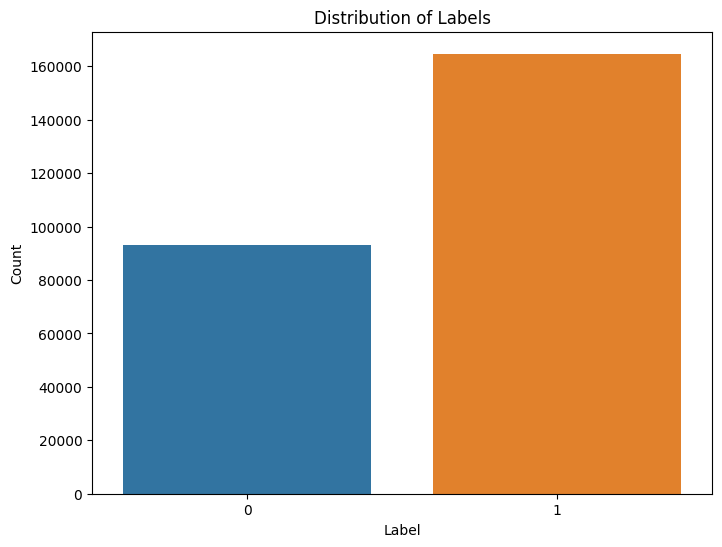

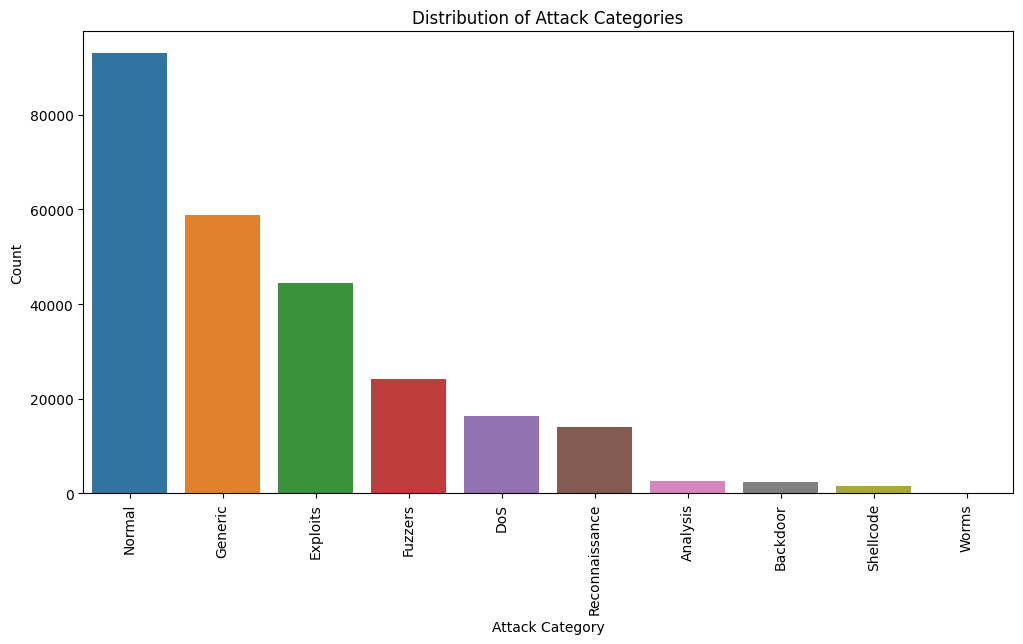

In [2]:
import time
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from tensorflow.python.client import device_lib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

devices = device_lib.list_local_devices()

# Early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

#The line of code 'GPUS = ["GPU:0"]' and 'strategy = tf.distribute.MirroredStrategy(GPUS)' should be commented when CPU is selected

GPUS = ["GPU:0"]
strategy = tf.distribute.MirroredStrategy( GPUS )
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

# Load dataset
train_data = pd.read_csv("UNSW_NB15_training-set.csv")
test_data = pd.read_csv("UNSW_NB15_testing-set.csv")

# Merge training and testing data
data = pd.concat([train_data, test_data], ignore_index=True)

# Count the occurrences of each class in 'attack_cat' and 'label'
attack_cat_counts = data['attack_cat'].value_counts()
label_counts = data['label'].value_counts()

# Print class distribution
print("Class distribution based on 'attack_cat':")
print(attack_cat_counts)
print("\nClass distribution based on 'label':")
print(label_counts)


# Plot the distribution of 'label' column
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

# Plot the distribution of 'attack_cat' column
plt.figure(figsize=(12, 6))
attack_cat_counts = data['attack_cat'].value_counts()
sns.barplot(x=attack_cat_counts.index, y=attack_cat_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.title('Distribution of Attack Categories')
plt.show()

# Convert categorical features to numerical features
categorical_features = data.select_dtypes(include=['object']).columns
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])

# Separate the data into features and targets
X = data.drop(columns=['label', 'attack_cat'])
y_binary = data['label']
y_multiclass = data['attack_cat']

# Normalize the features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets for binary classification
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

# Encode labels for binary classification
le_binary = LabelEncoder()
y_train_binary = le_binary.fit_transform(y_train_binary)
y_test_binary = le_binary.transform(y_test_binary)

# Split the data into training and testing sets for multi-class classification
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42
)

# Encode labels for multi-class classification
le_multiclass = LabelEncoder()
y_train_multiclass = le_multiclass.fit_transform(y_train_multiclass)
y_test_multiclass = le_multiclass.transform(y_test_multiclass)
y_train_multiclass = to_categorical(y_train_multiclass)
y_test_multiclass = to_categorical(y_test_multiclass)

# Reshape input data to match the expected input shape for CNN
X_train_binary = X_train_binary.values.reshape((X_train_binary.shape[0], X_train_binary.shape[1], 1))
X_test_binary = X_test_binary.values.reshape((X_test_binary.shape[0], X_test_binary.shape[1], 1))
X_train_multiclass = X_train_multiclass.values.reshape((X_train_multiclass.shape[0], X_train_multiclass.shape[1], 1))
X_test_multiclass = X_test_multiclass.values.reshape((X_test_multiclass.shape[0], X_test_multiclass.shape[1], 1))

In [3]:
# The strategy line code 'with strategy.scope():' should be commented when the CPU is used for the data processing
# The tabular space should be also eliminated to avoid errors

with strategy.scope():
    # Define the binary classification model
    model_binary = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_binary.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])


    # Define the multi-class classification model
    model_multiclass = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_multiclass.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(y_train_multiclass.shape[1], activation='softmax')
    ])

    # Compile the binary classification model
    model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Compile the multi-class classification model
    model_multiclass.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the binary classification model
    start_time_binary = time.time()
    model_binary.fit(
        X_train_binary, y_train_binary, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping_callback]
    )
    end_time_binary = time.time()

    # Train the multi-class classification model
    start_time_multiclass = time.time()
    model_multiclass.fit(
        X_train_multiclass, y_train_multiclass, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping_callback]
    )
    end_time_multiclass = time.time()

In [4]:
# Calculate training time for binary classification
training_time_binary = end_time_binary - start_time_binary
print("Binary Classification - Training Time:", training_time_binary, "seconds")

# Calculate training time for multi-class classification
training_time_multiclass = end_time_multiclass - start_time_multiclass
print("Multi-Class Classification - Training Time:", training_time_multiclass, "seconds")

Epoch 1/10
1289/1289 [==============================] - 16s 11ms/step - loss: 0.1605 - accuracy: 0.9250 - val_loss: 0.1100 - val_accuracy: 0.9517
Epoch 2/10
1289/1289 [==============================] - 14s 11ms/step - loss: 0.0995 - accuracy: 0.9579 - val_loss: 0.0988 - val_accuracy: 0.9587
Epoch 3/10
1289/1289 [==============================] - 14s 11ms/step - loss: 0.0861 - accuracy: 0.9637 - val_loss: 0.0823 - val_accuracy: 0.9658
Epoch 4/10
1289/1289 [==============================] - 14s 11ms/step - loss: 0.0803 - accuracy: 0.9657 - val_loss: 0.0762 - val_accuracy: 0.9671
Epoch 5/10
1289/1289 [==============================] - 14s 11ms/step - loss: 0.0768 - accuracy: 0.9669 - val_loss: 0.0743 - val_accuracy: 0.9683
Epoch 6/10
1289/1289 [==============================] - 14s 11ms/step - loss: 0.0735 - accuracy: 0.9687 - val_loss: 0.0831 - val_accuracy: 0.9635
Epoch 7/10
1289/1289 [==============================] - 14s 11ms/step - loss: 0.0713 - accuracy: 0.9698 - val_loss: 0.0684 -

In [5]:
# Evaluate the binary classification model
binary_loss, binary_accuracy = model_binary.evaluate(X_test_binary, y_test_binary)
print("Binary Classification - Test Loss:", binary_loss)
print("Binary Classification - Test Accuracy:", binary_accuracy)

# Evaluate the multi-class classification model
multiclass_loss, multiclass_accuracy = model_multiclass.evaluate(X_test_multiclass, y_test_multiclass)
print("Multi-Class Classification - Test Loss:", multiclass_loss)
print("Multi-Class Classification - Test Accuracy:", multiclass_accuracy)

1611/1611 [==============================] - 4s 2ms/step - loss: 0.0657 - accuracy: 0.9717
Binary Classification - Test Loss: 0.06571460515260696
Binary Classification - Test Accuracy: 0.9717279672622681
1611/1611 [==============================] - 3s 2ms/step - loss: 0.4231 - accuracy: 0.8389
Multi-Class Classification - Test Loss: 0.42305880784988403
Multi-Class Classification - Test Accuracy: 0.8388667702674866


In [6]:
# Obtain the model predictions for binary classification
y_pred_binary = model_binary.predict(X_test_binary)
y_pred_binary = (y_pred_binary > 0.5).astype(int)  # Convert to binary classes (0 or 1)

# Calculate metrics for binary classification model
f1_binary = f1_score(y_test_binary, y_pred_binary)
recall_binary = recall_score(y_test_binary, y_pred_binary)
precision_binary = precision_score(y_test_binary, y_pred_binary)

# Obtain model predictions for multi-class classification
y_prob_multiclass = model_multiclass.predict(X_test_multiclass)

# Convert probabilities to predicted classes
y_pred_multiclass = np.argmax(y_prob_multiclass, axis=1)

# Convert test labels (y_test_multiclass) to predicted classes encoded as integers
y_test_pred_multiclass = np.argmax(y_test_multiclass, axis=1)

# Calculate metrics for multi-class classification model
f1_multiclass = f1_score(y_test_pred_multiclass, y_pred_multiclass, average='weighted')
recall_multiclass = recall_score(y_test_pred_multiclass, y_pred_multiclass, average='weighted')
precision_multiclass = precision_score(y_test_pred_multiclass, y_pred_multiclass, average='weighted')

print("Binary Classification - F1 Score:", f1_binary)
print("Binary Classification - Recall:", recall_binary)
print("Binary Classification - Precision:", precision_binary)

print("Multi-Class Classification - F1 Score:", f1_multiclass)
print("Multi-Class Classification - Recall:", recall_multiclass)
print("Multi-Class Classification - Precision:", precision_multiclass)

1611/1611 [==============================] - 3s 2ms/step
Binary Classification - F1 Score: 0.9776290131892091
Binary Classification - Recall: 0.9688374923919659
Binary Classification - Precision: 0.9865815488549382
Multi-Class Classification - F1 Score: 0.8269725374725437
Multi-Class Classification - Recall: 0.8388667895604929
Multi-Class Classification - Precision: 0.8294175095911712


/home/ubuntu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


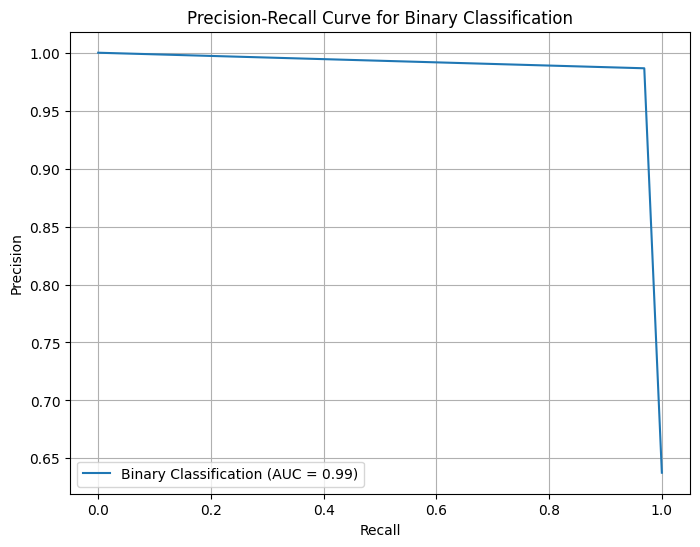

In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Calculate precision-recall curve for binary classification
precision_binary, recall_binary, thresholds_binary = precision_recall_curve(y_test_binary, y_pred_binary)

# Calculate Area Under the Precision-Recall Curve (AUC-PR) for binary classification
auc_binary = auc(recall_binary, precision_binary)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_binary, precision_binary, label='Binary Classification (AUC = {:.2f})'.format(auc_binary))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Binary Classification')
plt.legend(loc='best')
plt.grid(True)
plt.show()

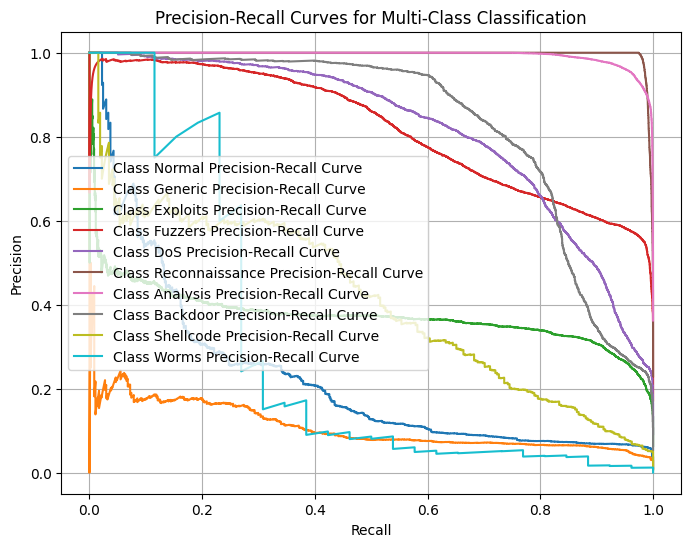

In [8]:
# Create a dictionary to map encoded labels to real class names
label_to_class_name = {
    0: 'Normal',
    1: 'Generic',
    2: 'Exploits',
    3: 'Fuzzers',
    4: 'DoS',
    5: 'Reconnaissance',
    6: 'Analysis',
    7: 'Backdoor',
    8: 'Shellcode',
    9: 'Worms'
}

# Calculate precision-recall curve for multi-class classification
precision_multiclass = dict()
recall_multiclass = dict()
for i in range(y_test_multiclass.shape[1]):
    precision_multiclass[i], recall_multiclass[i], _ = precision_recall_curve(y_test_multiclass[:, i], y_prob_multiclass[:, i])

# Plot the precision-recall curves for each class in multi-class classification
plt.figure(figsize=(8, 6))
for i in range(y_test_multiclass.shape[1]):
    plt.plot(recall_multiclass[i], precision_multiclass[i], label='Class {} Precision-Recall Curve'.format(label_to_class_name[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-Class Classification')
plt.legend(loc='best')
plt.grid(True)
plt.show()

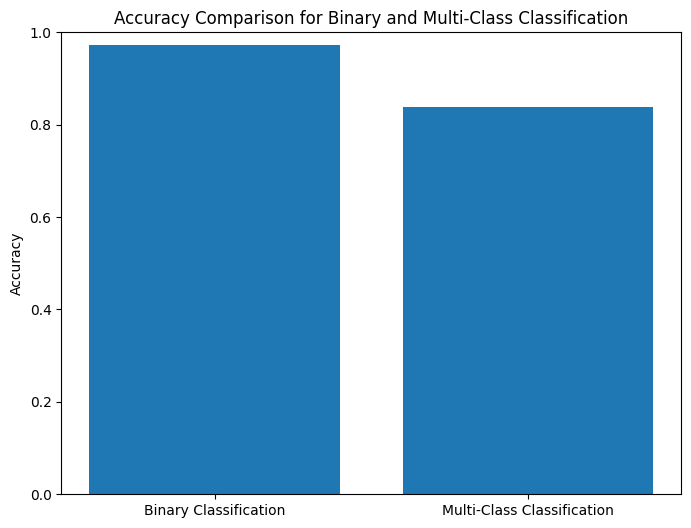

In [9]:
# Accuracy for binary classification
accuracy_binary = binary_accuracy

# Accuracy for multi-class classification
accuracy_multiclass = multiclass_accuracy

# Plot the accuracies
plt.figure(figsize=(8, 6))
plt.bar(['Binary Classification', 'Multi-Class Classification'], [accuracy_binary, accuracy_multiclass])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Binary and Multi-Class Classification')
plt.show()

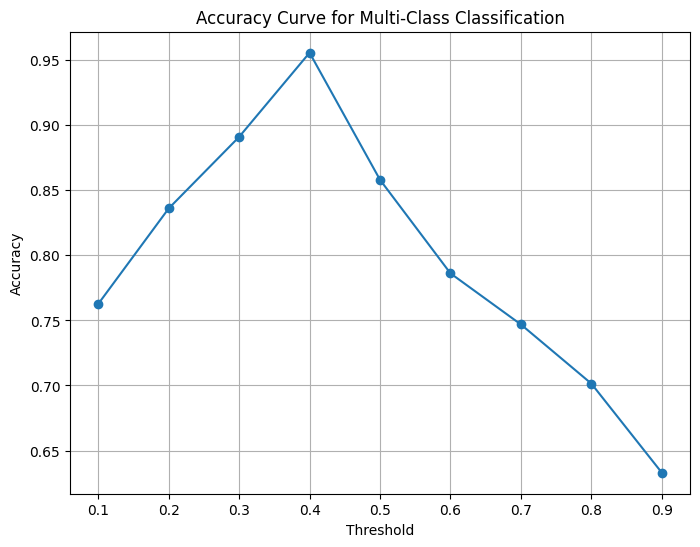

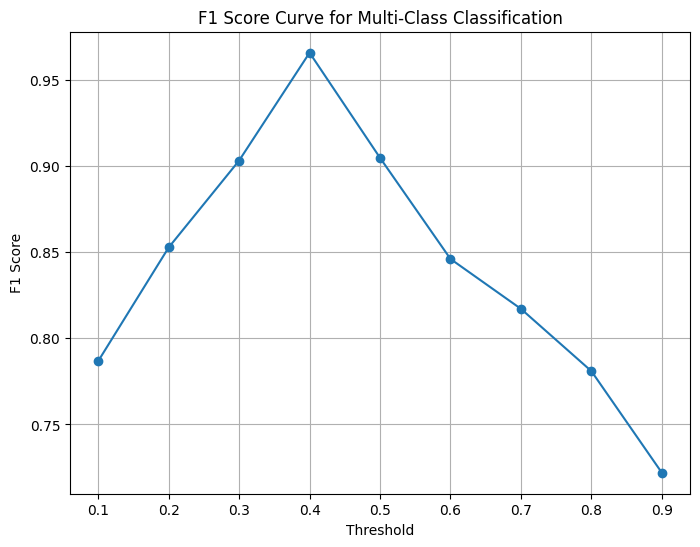

In [10]:
# Calculate accuracy and F1 score for multi-class classification at different thresholds
thresholds = np.arange(0.1, 1.0, 0.1)  # You can adjust the range of thresholds as per your requirement

accuracies = []
f1_scores = []

for threshold in thresholds:
    # Convert probabilities to predicted classes using the threshold
    y_pred_multiclass_thresholded = (y_prob_multiclass >= threshold).astype(int)

    # Convert test labels to predicted classes encoded as integers
    y_test_pred_multiclass_thresholded = y_prob_multiclass.argmax(axis=1)

    # Calculate accuracy and F1 score for the thresholded predictions
    accuracy = accuracy_score(y_test_pred_multiclass_thresholded, y_pred_multiclass_thresholded.argmax(axis=1))
    f1 = f1_score(y_test_pred_multiclass_thresholded, y_pred_multiclass_thresholded.argmax(axis=1), average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)

# Plot the accuracy curve for multi-class classification
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Multi-Class Classification')
plt.grid(True)
plt.show()

# Plot the F1 score curve for multi-class classification
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve for Multi-Class Classification')
plt.grid(True)
plt.show()

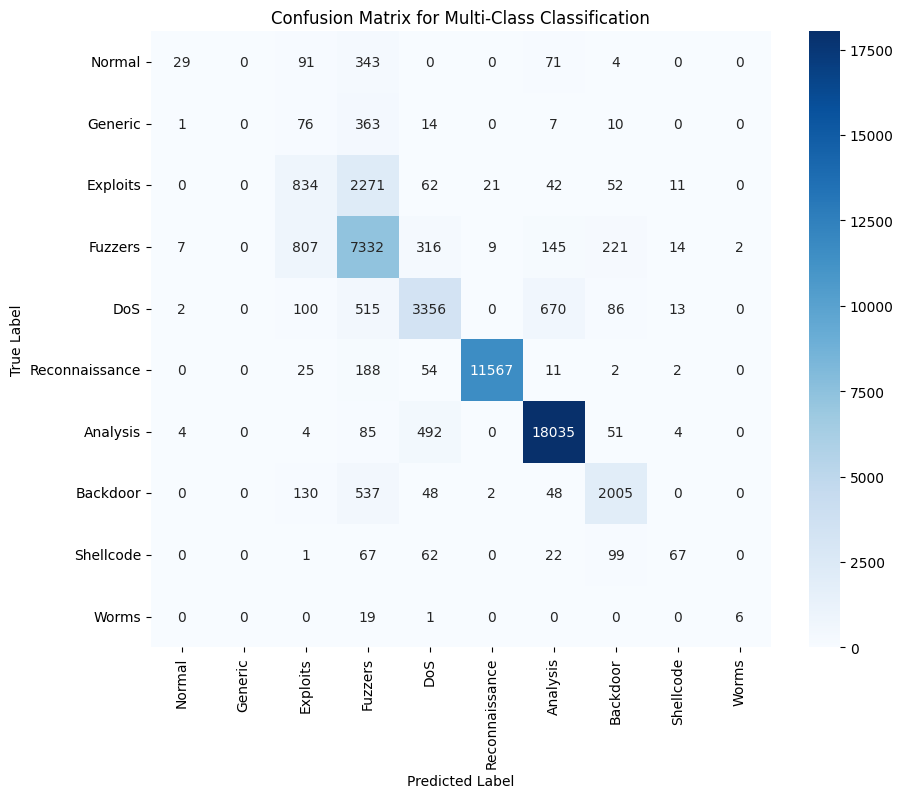

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix for multi-class classification
conf_matrix_multiclass = confusion_matrix(y_test_pred_multiclass, y_pred_multiclass)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_multiclass, annot=True, cmap='Blues', fmt='d', xticklabels=label_to_class_name.values(), yticklabels=label_to_class_name.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.show()